In [1]:
import scvelo as scv
scv.settings.verbosity = 0
dataset = '../data/Melania/erythroids_mouse.h5'
label = 'celltype'
exp_metrics = {}

In [2]:
import unitvelo as utv

(Running UniTVelo 0.1.0)
2022-03-27 09:16:41


In [3]:
cluster_edges = [
    ("Blood progenitors 1", "Blood progenitors 2"), 
    ("Blood progenitors 2", "Erythroid1"),
    ("Erythroid1", "Erythroid2"), 
    ("Erythroid2", "Erythroid3")]

## scVelo stochastic

  0%|          | 0.00/463M [00:00<?, ?B/s]

  0%|          | 0/9815 [00:00<?, ?cells/s]

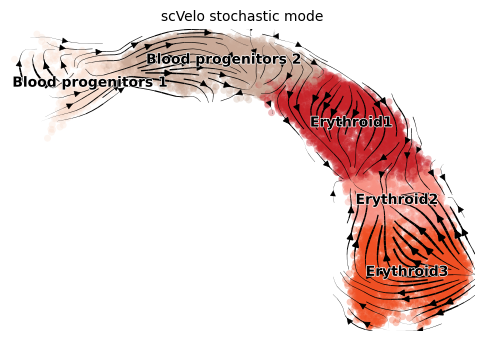

In [5]:
title = 'scVelo stochastic mode'
adata = scv.datasets.gastrulation_erythroid()
adata.uns['datapath'] = dataset
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata, mode='stochastic')

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title=title)

In [5]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): 0.5113172068905634, ('Blood progenitors 2', 'Erythroid1'): 0.2193379413016088, ('Erythroid1', 'Erythroid2'): 0.2607211173229193, ('Erythroid2', 'Erythroid3'): -0.5233623472264748}
Total Mean: 0.11700347957215418
# In-cluster Coherence
{'Blood progenitors 1': 0.7469426, 'Blood progenitors 2': 0.6420871, 'Erythroid1': 0.7093799, 'Erythroid2': 0.6696792, 'Erythroid3': 0.93360704}
Total Mean: 0.7403391599655151


## scVelo dynamic

  0%|          | 0/590 [00:00<?, ?gene/s]

  0%|          | 0/9815 [00:00<?, ?cells/s]

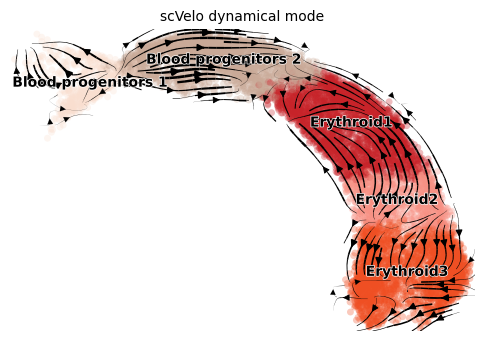

In [6]:
title = 'scVelo dynamical mode'
adata = scv.datasets.gastrulation_erythroid()
adata.uns['datapath'] = dataset
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title=title)

In [5]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): -0.13390616089490887, ('Blood progenitors 2', 'Erythroid1'): -0.10421275135600866, ('Erythroid1', 'Erythroid2'): -0.7850973403792504, ('Erythroid2', 'Erythroid3'): -0.6741979524369763}
Total Mean: -0.4243535512667861
# In-cluster Coherence
{'Blood progenitors 1': 0.8005856317554908, 'Blood progenitors 2': 0.8120516536080526, 'Erythroid1': 0.8809079181085062, 'Erythroid2': 0.8845799090102205, 'Erythroid3': 0.8334101149556873}
Total Mean: 0.8423070454875914


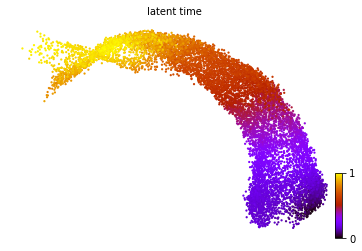

In [7]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

## UniTVelo

In [8]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = '1'

-------> Model Configuration Settings <-------

 GPU: 2	FIG_DIR: ./figures/	BASE_FUNCTION: Gaussian	
 GENERAL: Curve	BASIS: None	N_TOP_GENES: 2000	
 OFFSET_GENES: False	FILTER_CELLS: False	EXAMINE_GENE: False	
 RESCALE_TIME: False	RESCALE_DATA: True	R2_ADJUST: True	
 IROOT: None	NUM_REPEAT: 1	FIT_OPTION: 1	
 DENSITY: SVD	REORDER_CELL: Soft_Reorder	AGGREGATE_T: True	
 ASSIGN_POS_U: False	WIN_SIZE: 50	LEARNING_RATE: 0.01	
 MAX_ITER: 10000	USE_RAW: False	RAW_GENES: False	

---> # of velocity genes used 513
---> # of velocity genes used 505
---> # of velocity genes used 503


  0%|          | 0/10000 [00:00<?, ?it/s]

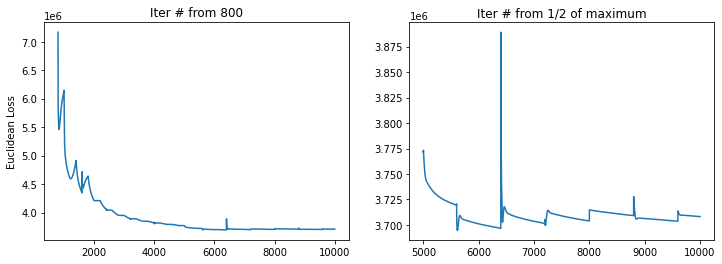

  0%|          | 0/9815 [00:00<?, ?cells/s]

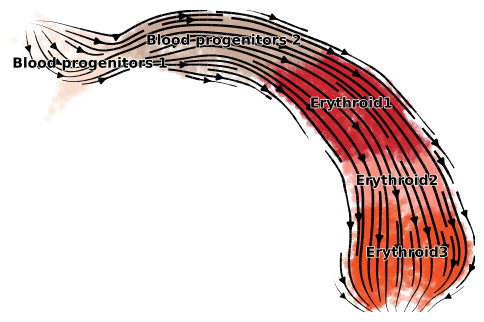

In [9]:
adata = utv.run_model('data/Gastrulation/erythroid_lineage.h5ad', label, config_file=velo_config)
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='')

In [ ]:
adata.uns['celltype_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c']

In [6]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity')

# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): 0.9073857178607169, ('Blood progenitors 2', 'Erythroid1'): 0.764143490806454, ('Erythroid1', 'Erythroid2'): 0.8304136478666694, ('Erythroid2', 'Erythroid3'): 0.8282189974445031}
Total Mean: 0.8325404634945859
# In-cluster Coherence
{'Blood progenitors 1': 0.9842396269486656, 'Blood progenitors 2': 0.9751641967835233, 'Erythroid1': 0.9908564641677945, 'Erythroid2': 0.9956236842608082, 'Erythroid3': 0.9961465798754442}
Total Mean: 0.9884061104072472


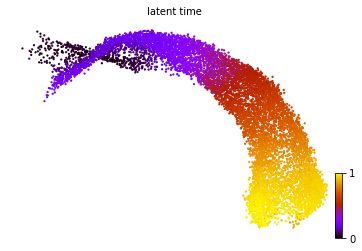

In [10]:
scv.tl.latent_time(adata, min_likelihood=None)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

In [11]:
subvar = adata.var.loc[adata.var['velocity_genes'] == True]
sub = adata[:, subvar.index]

Text(0.5, 1.0, 'Peak Time')

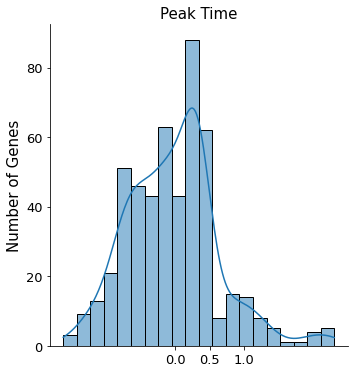

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(sub.var['fit_t0'].values, kde=True, bins=20)
plt.xticks([0, 0.5, 1], fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Number of Genes', fontsize=15)
plt.title('Peak Time', fontsize=15)

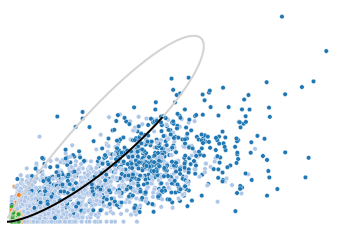

0 1 -0.2241704
0 1 -0.2241704
0 1 -0.2241704


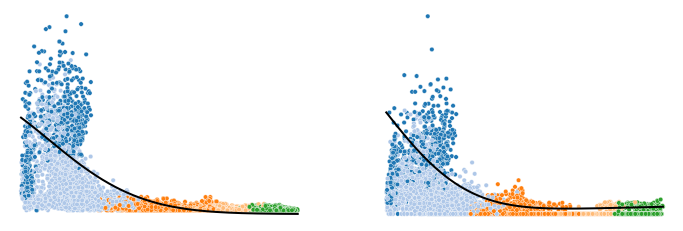

In [13]:
utv.pl.plot_range('Cyr61', adata, velo_config, 
    show_legend=False, show_ax=False, show_temporal=True, 
    t_left=0, t_right=1, time_metric='latent_time')

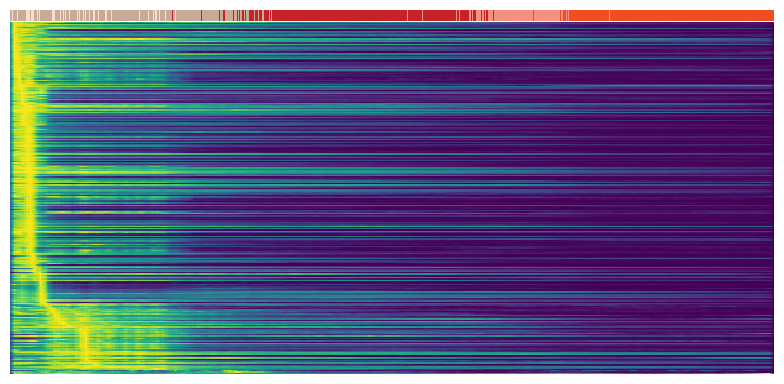

In [14]:
sns.set(rc={"figure.dpi":100})
gene = sub.var.loc[sub.var['fit_t0'] < 0.05].index
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color='celltype', n_convolve=100)

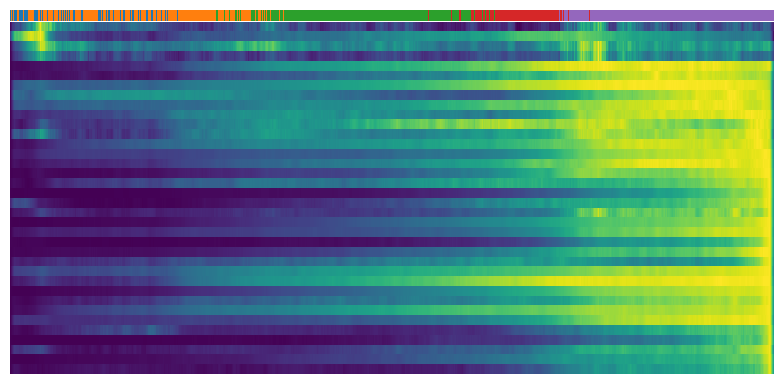

In [22]:
gene = sub.var.loc[sub.var['fit_t0'] > 0.95].index
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color='celltype', n_convolve=100)

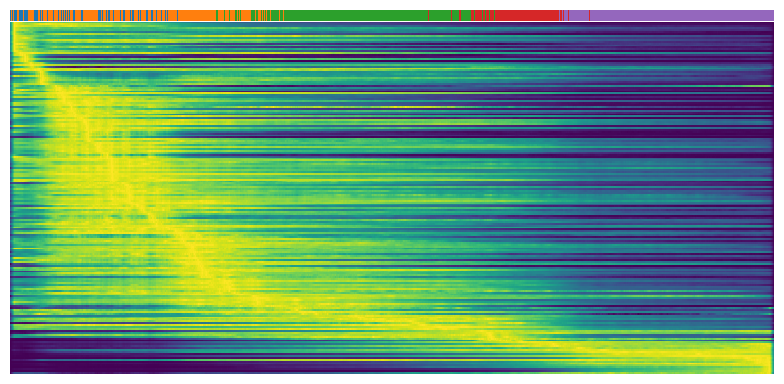

In [23]:
gene = sub.var.loc[(sub.var['fit_t0'] > 0.05) & (sub.var['fit_t0'] < 0.95)].index
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color='celltype', n_convolve=100)

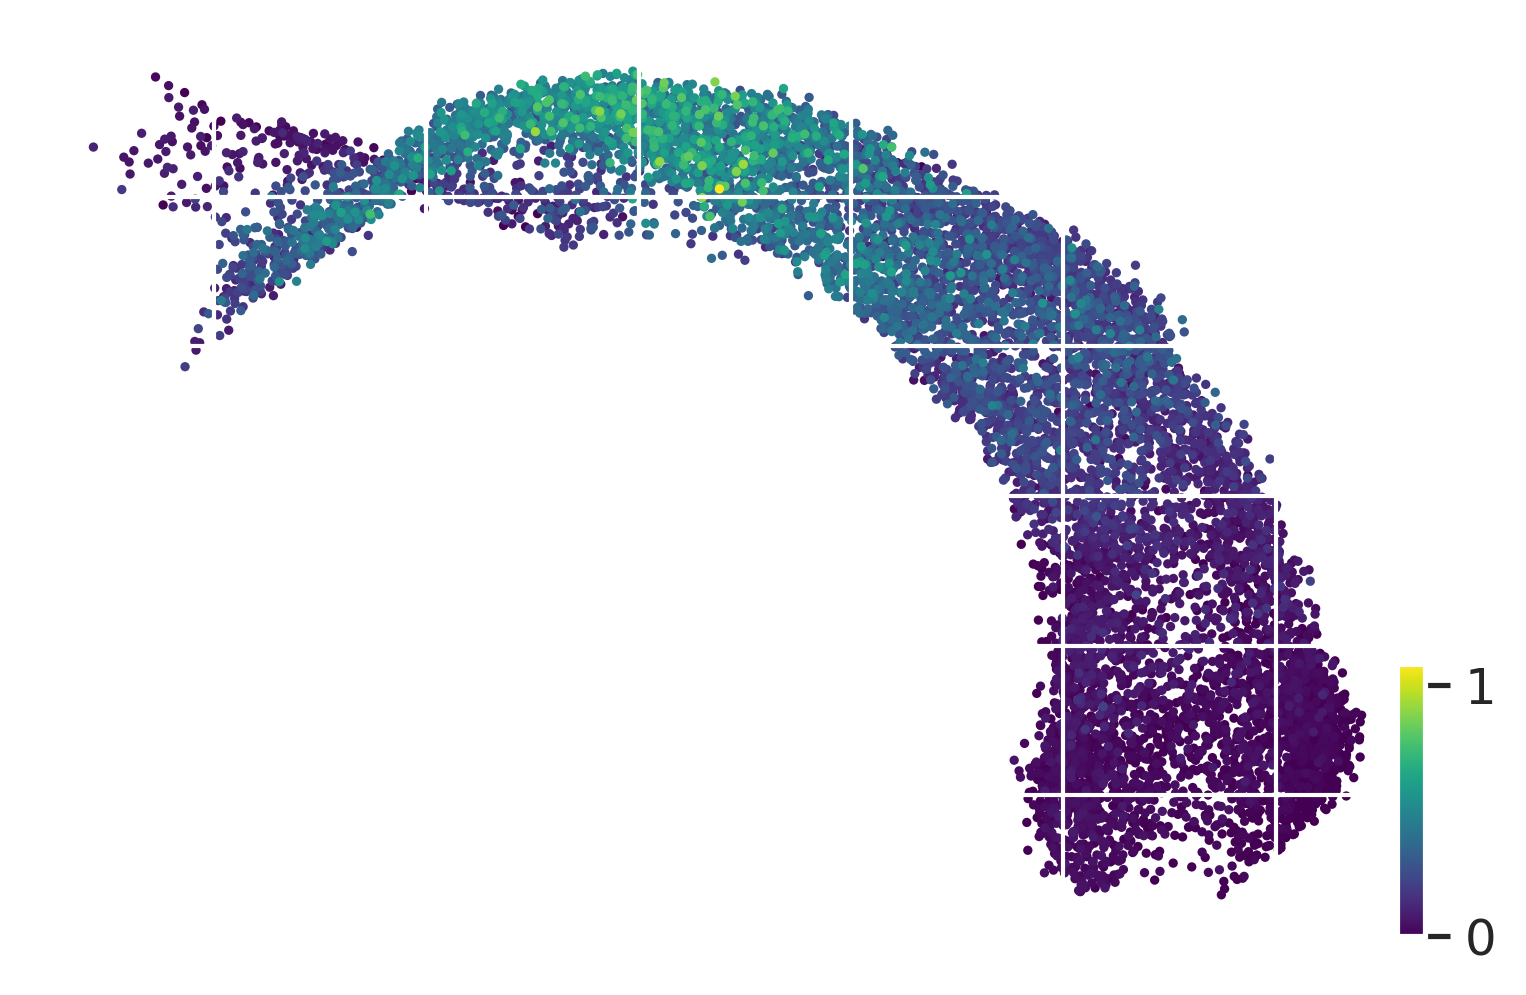

In [24]:
gene_name = 'Scube2'
adata.obs['temp'] = adata[:, gene_name].layers['Ms']
scv.pl.scatter(adata, color='temp', color_map='viridis', size=20, dpi=300, title='')

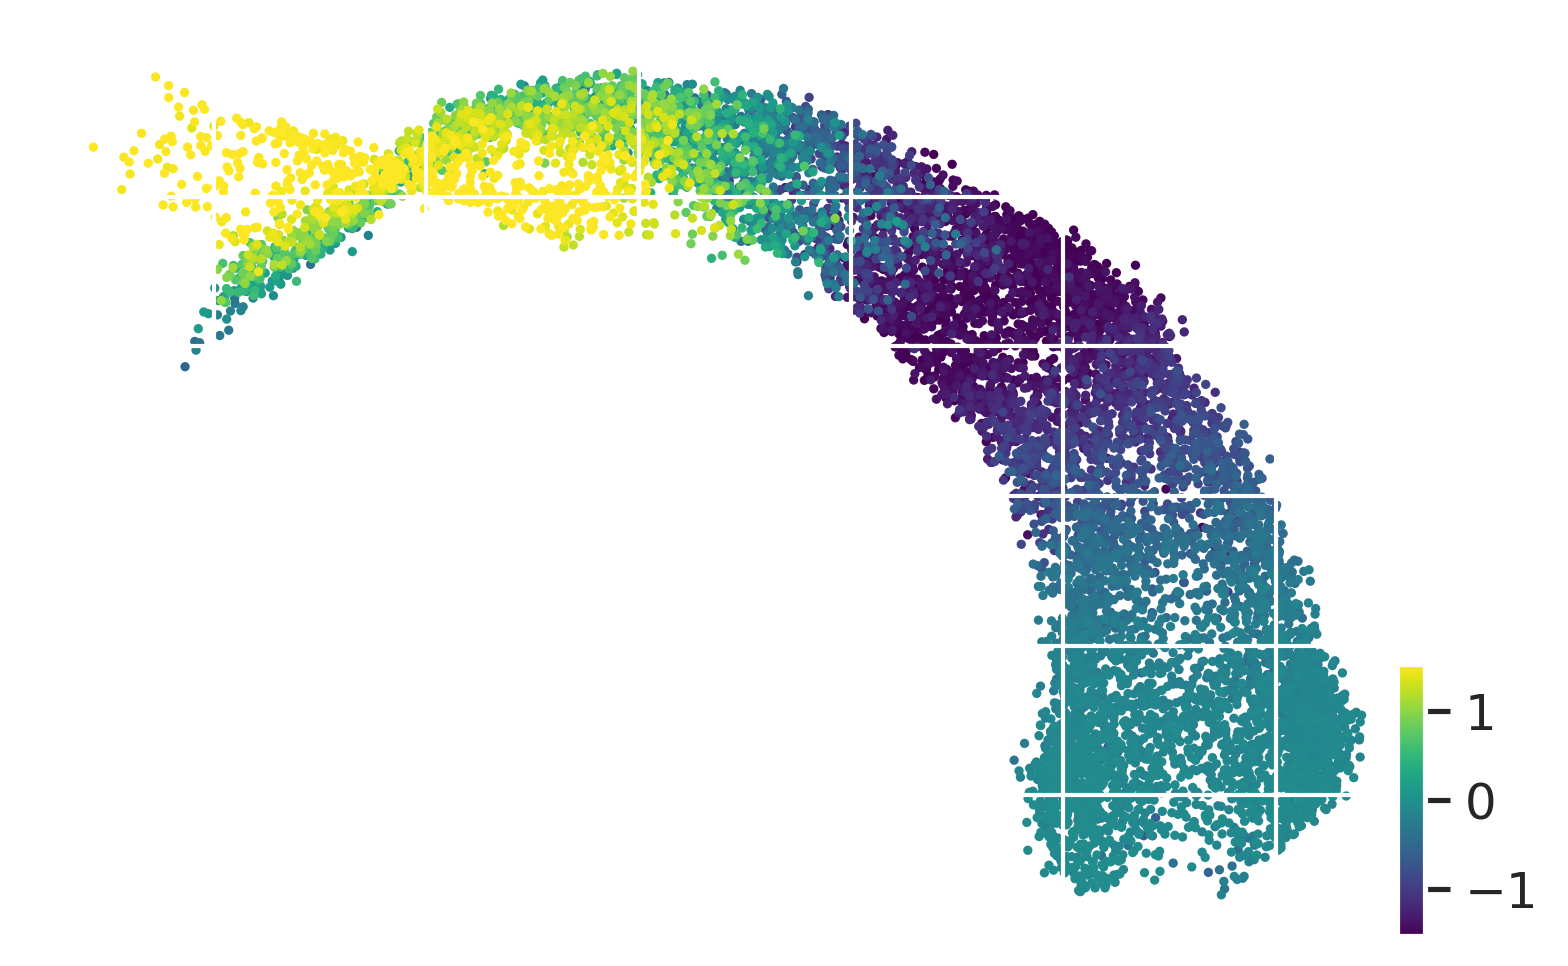

In [25]:
gene_name = 'Scube2'
adata.obs['temp'] = adata[:, gene_name].layers['velocity']
scv.pl.scatter(adata, color='temp', color_map='viridis', size=20, dpi=300, title='')